# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [4]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [5]:
def trim_df(df, param):
    
    '''
    This function drops columns that include data with more than 
    more than the given parameter of the missing rows '''
    
    percent = param
    
    null_percentages  = (df.isnull().sum()/df.shape[0]).sort_values(ascending = False)
    
    null_percentages = pd.DataFrame(null_percentages)
    
    drop_list = list((null_percentages.loc[(null_percentages[0] > percent) == True]).index.values)

    df.drop(labels = drop_list, axis = 1, inplace = True)
    
    return df   
    

In [6]:
new_azdias = trim_df(azdias, .0001)

In [7]:
new_azdias.columns

Index(['LNR', 'AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
       'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D

In [8]:
new_customers = trim_df(customers, .0001)

In [9]:
azdias.head()

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,0,0,10,0,0,0,10,10,...,4,7,2,3,1,-1,-1,3,1,2
1,910220,-1,0,0,10,0,0,0,10,10,...,6,4,5,6,1,3,2,5,2,1
2,910225,-1,0,0,10,0,0,0,10,10,...,4,3,4,3,4,2,1,5,2,3
3,910226,2,0,0,10,0,0,0,10,10,...,3,2,5,4,4,1,1,3,2,4
4,910241,-1,3,5,5,1,2,0,10,5,...,2,4,6,2,7,2,2,4,1,3


In [10]:
customers.head()

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,0,0,10,0,0,0,10,10,...,1,6,3,1,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,0,1,6,0,5,0,10,10,...,1,7,3,1,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,0,0,10,0,0,0,10,10,...,1,3,1,2,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,0,0,10,0,0,0,10,10,...,4,7,0,1,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1,2,3,5,0,3,10,7,...,4,5,1,2,1,FOOD,MULTI_BUYER,0,1,3


In [11]:
def plot_comparison(country, customers, string_col):

    x = country.value_counts().index.values

    y1 = country.value_counts()/len(country)

    y2 = customers.value_counts()/len(customers)

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.bar(x, y1)
    ax1.set_title('Population')
    ax2.bar(x, y2)
    ax2.set_title('Customers')
    plt.show()

In [12]:
common = list(set(new_azdias.columns).intersection(set(new_customers.columns)))

# drop LNR
common.remove('LNR')
# drop GEBURTSJAHR
#common.remove('GEBURTSJAHR')
common

['D19_GESAMT_ANZ_12',
 'GREEN_AVANTGARDE',
 'D19_BIO_OEKO',
 'D19_GESAMT_ANZ_24',
 'SEMIO_RAT',
 'ALTERSKATEGORIE_GROB',
 'FINANZ_HAUSBAUER',
 'D19_HANDWERK',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_REST',
 'SEMIO_FAM',
 'D19_TELKO_MOBILE',
 'FINANZ_SPARER',
 'SEMIO_REL',
 'D19_TELKO_OFFLINE_DATUM',
 'GEBURTSJAHR',
 'D19_BEKLEIDUNG_REST',
 'D19_SAMMELARTIKEL',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BEKLEIDUNG_GEH',
 'D19_VOLLSORTIMENT',
 'SEMIO_KULT',
 'D19_ENERGIE',
 'D19_TECHNIK',
 'SEMIO_DOM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_BUCH_CD',
 'FINANZTYP',
 'D19_BANKEN_LOKAL',
 'FINANZ_VORSORGER',
 'D19_BANKEN_ANZ_24',
 'SEMIO_LUST',
 'D19_TELKO_DATUM',
 'AGER_TYP',
 'D19_TIERARTIKEL',
 'D19_TELKO_ONLINE_DATUM',
 'D19_NAHRUNGSERGAENZUNG',
 'NATIONALITAET_KZ',
 'ZABEOTYP',
 'SEMIO_SOZ',
 'FINANZ_MINIMALIST',
 'D19_HAUS_DEKO',
 'D19_TELKO_ANZ_12',
 'D19_VERSAND_REST',
 'SEMIO_ERL',
 'SEMIO_KRIT',
 'D19_BILDUNG',
 'D19_DROGERIEARTIKEL',
 

plot number:  0  plot name:  D19_GESAMT_ANZ_12


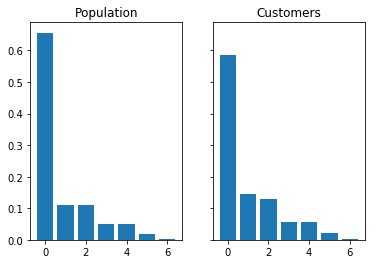

plot number:  1  plot name:  GREEN_AVANTGARDE


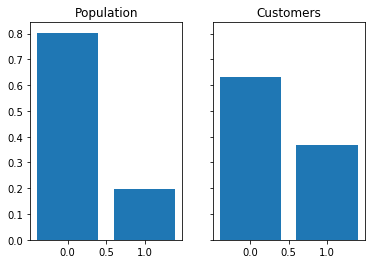

plot number:  2  plot name:  D19_BIO_OEKO


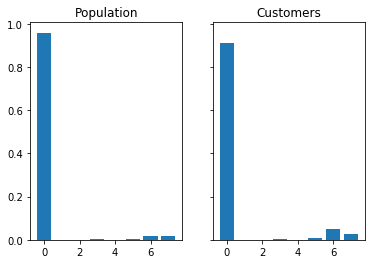

plot number:  3  plot name:  D19_GESAMT_ANZ_24


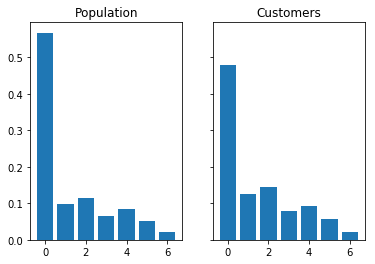

plot number:  4  plot name:  SEMIO_RAT


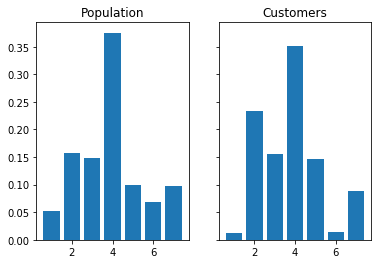

plot number:  5  plot name:  ALTERSKATEGORIE_GROB


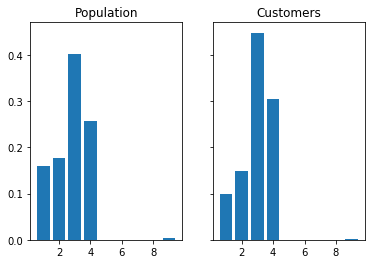

plot number:  6  plot name:  FINANZ_HAUSBAUER


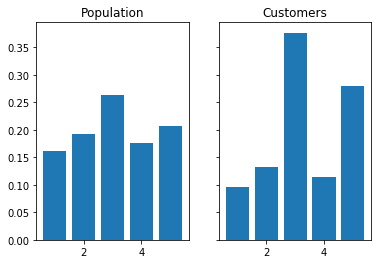

plot number:  7  plot name:  D19_HANDWERK


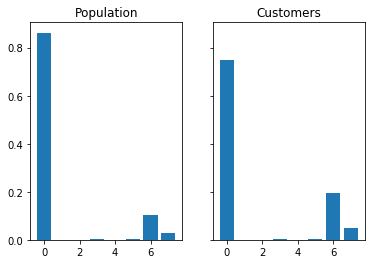

plot number:  8  plot name:  D19_TELKO_ANZ_24


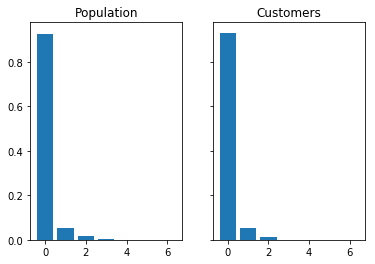

plot number:  9  plot name:  D19_TELKO_REST


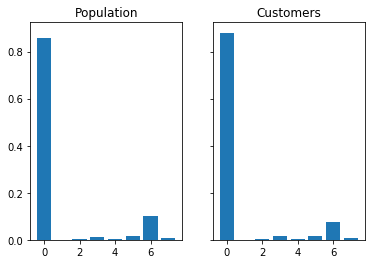

plot number:  10  plot name:  SEMIO_FAM


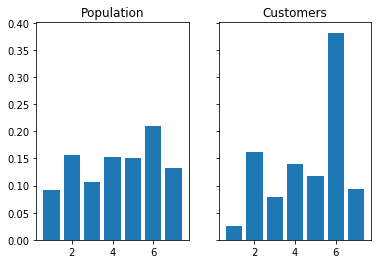

plot number:  11  plot name:  D19_TELKO_MOBILE


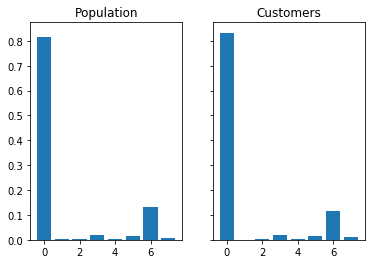

plot number:  12  plot name:  FINANZ_SPARER


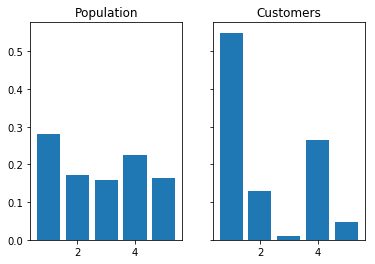

plot number:  13  plot name:  SEMIO_REL


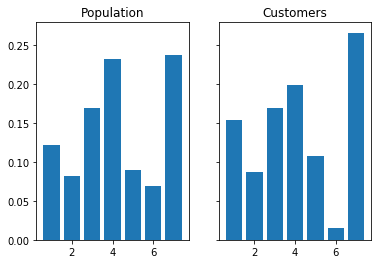

plot number:  14  plot name:  D19_TELKO_OFFLINE_DATUM


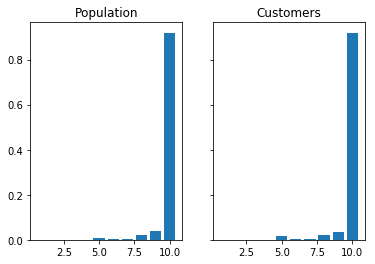

plot number:  15  plot name:  GEBURTSJAHR
skipped feature
plot number:  15  plot name:  D19_BEKLEIDUNG_REST


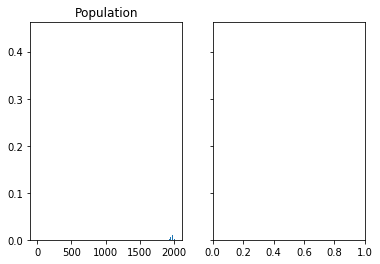

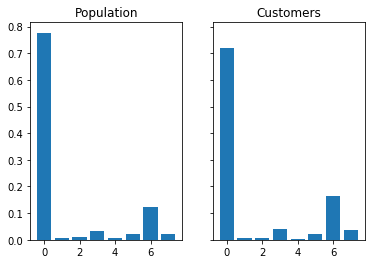

plot number:  16  plot name:  D19_SAMMELARTIKEL


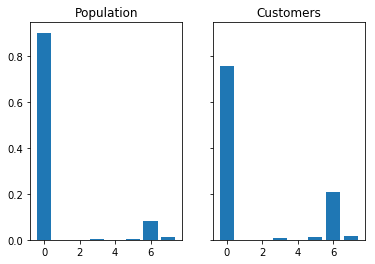

plot number:  17  plot name:  D19_BANKEN_DIREKT


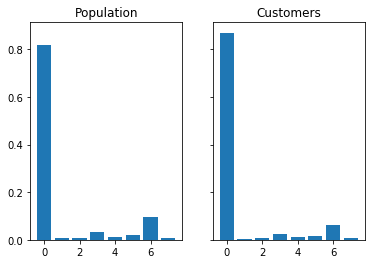

plot number:  18  plot name:  D19_BANKEN_GROSS


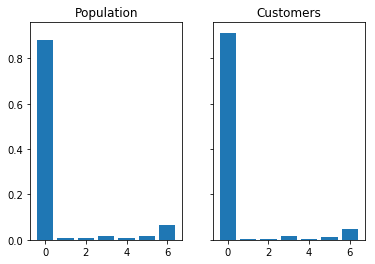

plot number:  19  plot name:  D19_BEKLEIDUNG_GEH


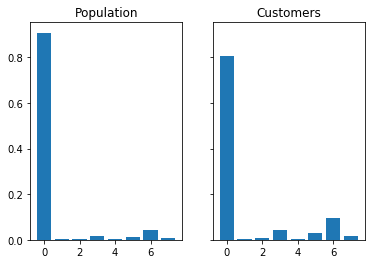

plot number:  20  plot name:  D19_VOLLSORTIMENT


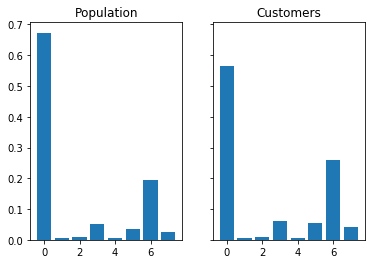

plot number:  21  plot name:  SEMIO_KULT


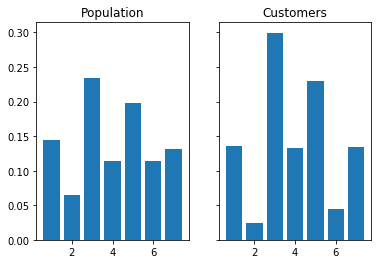

plot number:  22  plot name:  D19_ENERGIE


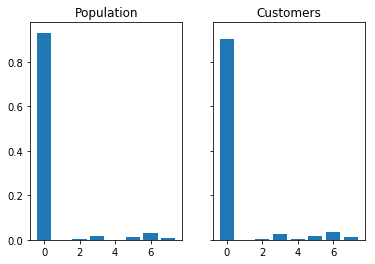

plot number:  23  plot name:  D19_TECHNIK


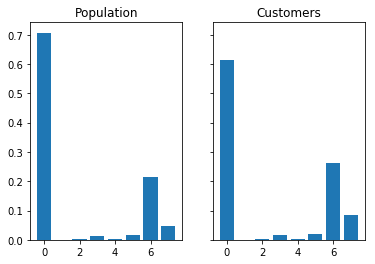

plot number:  24  plot name:  SEMIO_DOM


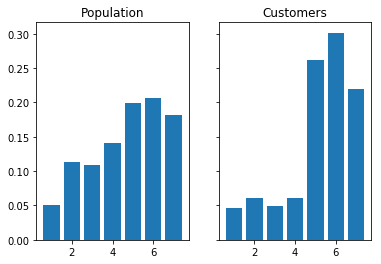

plot number:  25  plot name:  D19_VERSI_OFFLINE_DATUM


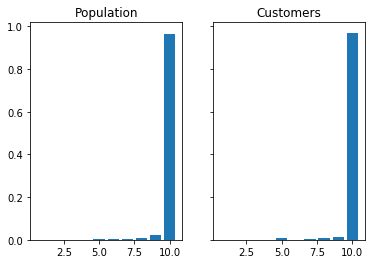

plot number:  26  plot name:  D19_VERSAND_ANZ_12


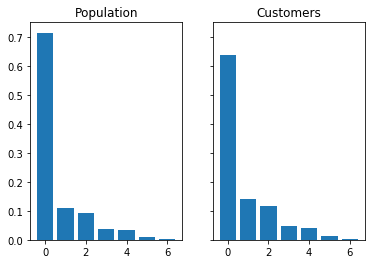

plot number:  27  plot name:  D19_GESAMT_ONLINE_DATUM


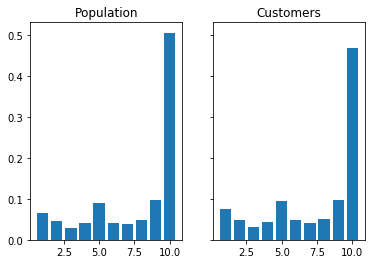

plot number:  28  plot name:  D19_BUCH_CD


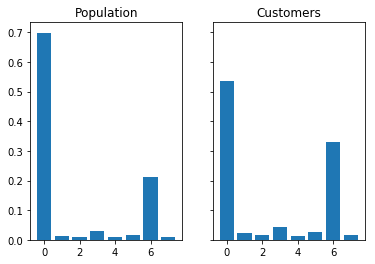

plot number:  29  plot name:  FINANZTYP


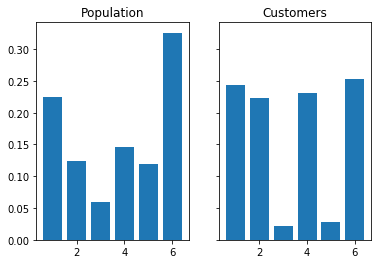

plot number:  30  plot name:  D19_BANKEN_LOKAL


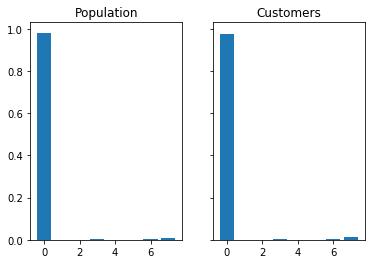

plot number:  31  plot name:  FINANZ_VORSORGER


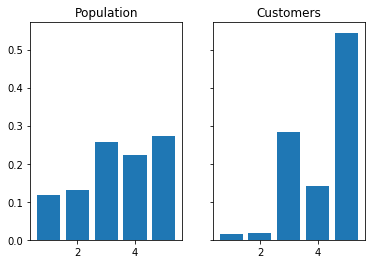

plot number:  32  plot name:  D19_BANKEN_ANZ_24


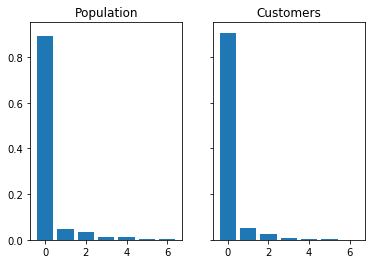

plot number:  33  plot name:  SEMIO_LUST


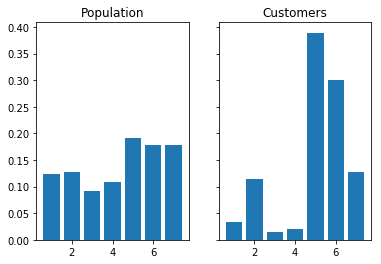

plot number:  34  plot name:  D19_TELKO_DATUM


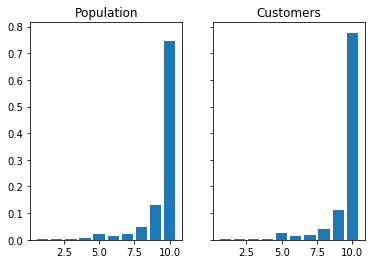

plot number:  35  plot name:  AGER_TYP


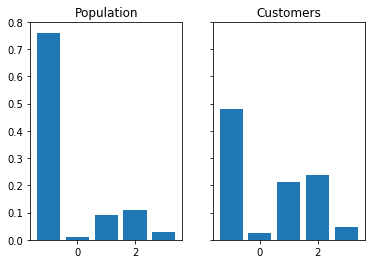

plot number:  36  plot name:  D19_TIERARTIKEL


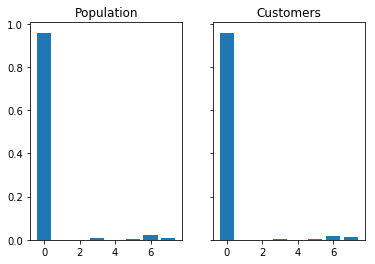

plot number:  37  plot name:  D19_TELKO_ONLINE_DATUM


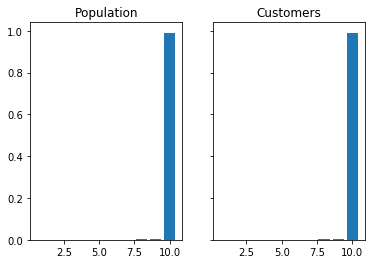

plot number:  38  plot name:  D19_NAHRUNGSERGAENZUNG


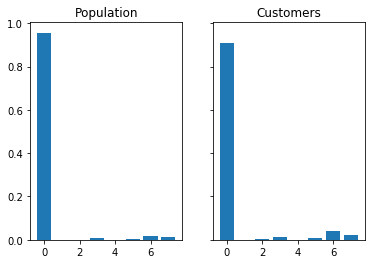

plot number:  39  plot name:  NATIONALITAET_KZ


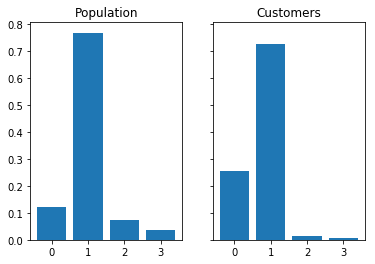

plot number:  40  plot name:  ZABEOTYP


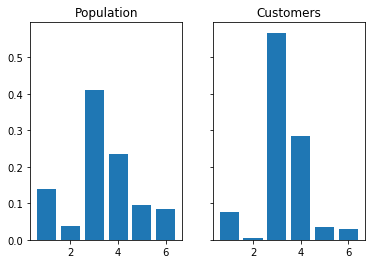

plot number:  41  plot name:  SEMIO_SOZ


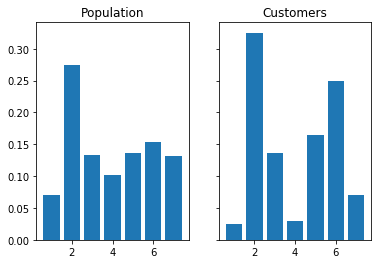

plot number:  42  plot name:  FINANZ_MINIMALIST


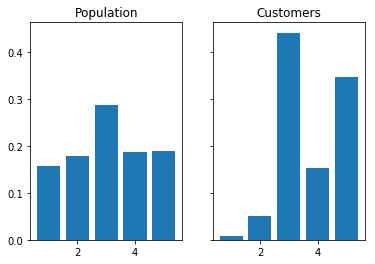

plot number:  43  plot name:  D19_HAUS_DEKO


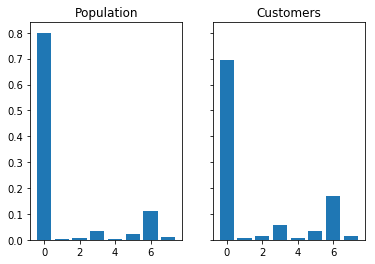

plot number:  44  plot name:  D19_TELKO_ANZ_12


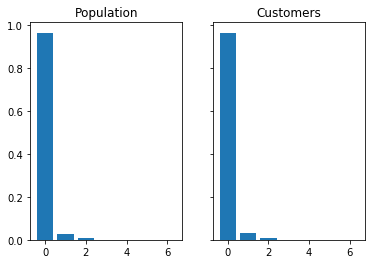

plot number:  45  plot name:  D19_VERSAND_REST


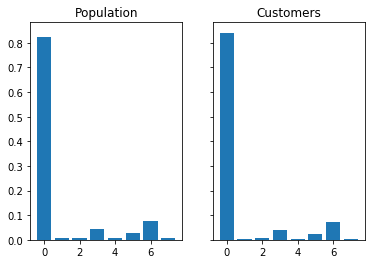

plot number:  46  plot name:  SEMIO_ERL


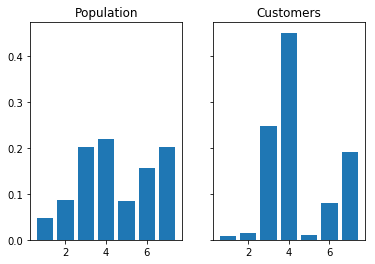

plot number:  47  plot name:  SEMIO_KRIT


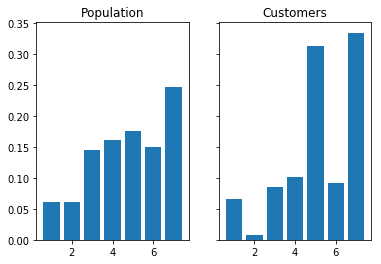

plot number:  48  plot name:  D19_BILDUNG


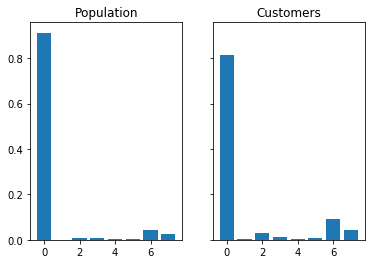

plot number:  49  plot name:  D19_DROGERIEARTIKEL


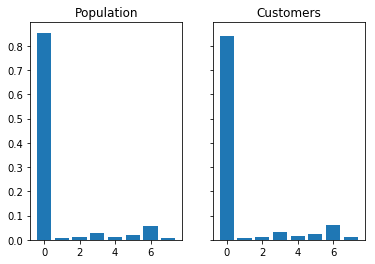

plot number:  50  plot name:  D19_VERSAND_DATUM


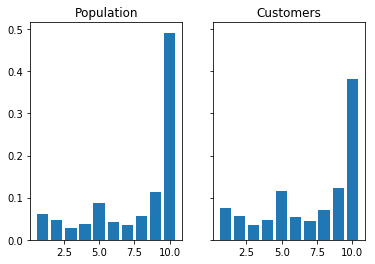

plot number:  51  plot name:  D19_FREIZEIT


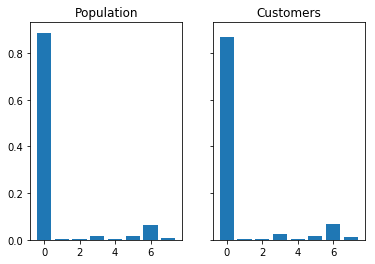

plot number:  52  plot name:  D19_SONSTIGE


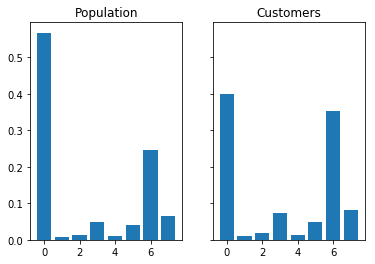

plot number:  53  plot name:  D19_KOSMETIK


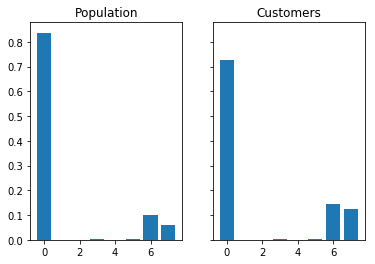

plot number:  54  plot name:  SHOPPER_TYP


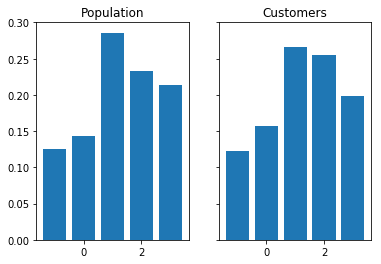

plot number:  55  plot name:  VERS_TYP


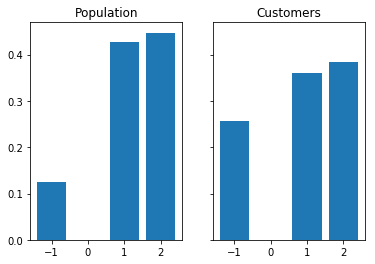

plot number:  56  plot name:  D19_BANKEN_REST


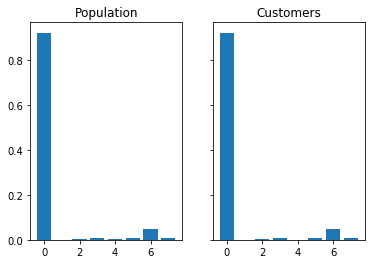

plot number:  57  plot name:  D19_VERSI_ONLINE_DATUM


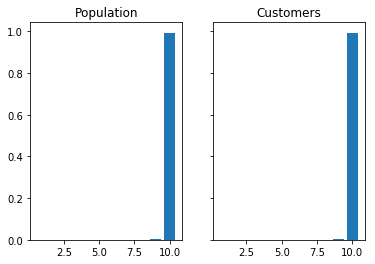

plot number:  58  plot name:  D19_BANKEN_OFFLINE_DATUM


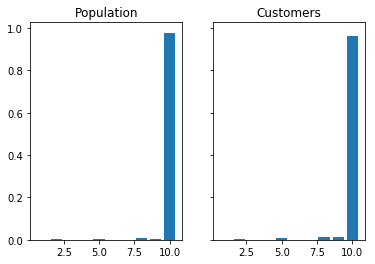

plot number:  59  plot name:  D19_BANKEN_ONLINE_DATUM


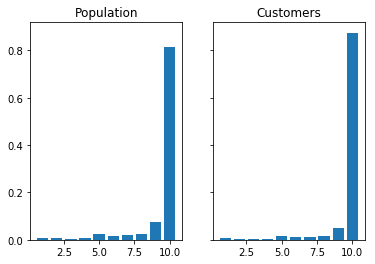

plot number:  60  plot name:  D19_GESAMT_OFFLINE_DATUM


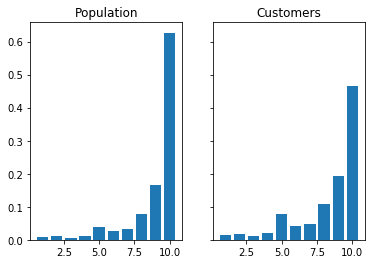

plot number:  61  plot name:  D19_VERSAND_OFFLINE_DATUM


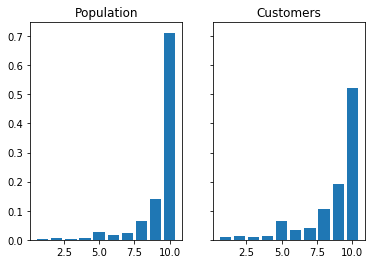

plot number:  62  plot name:  SEMIO_TRADV


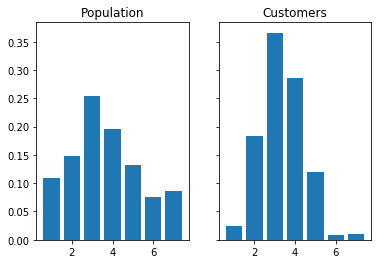

plot number:  63  plot name:  D19_VERSI_ANZ_24


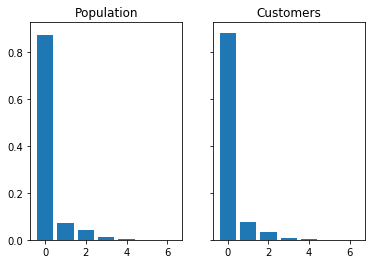

plot number:  64  plot name:  FINANZ_UNAUFFAELLIGER


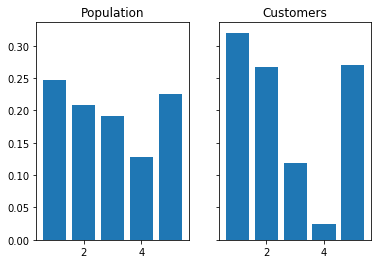

plot number:  65  plot name:  D19_REISEN


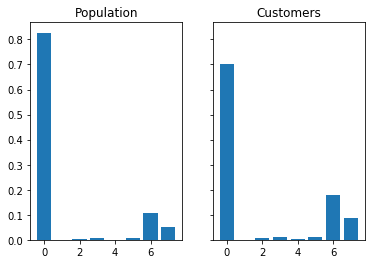

plot number:  66  plot name:  SEMIO_MAT


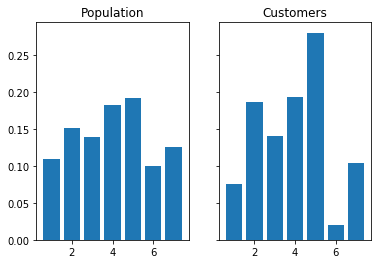

plot number:  67  plot name:  D19_BANKEN_ANZ_12


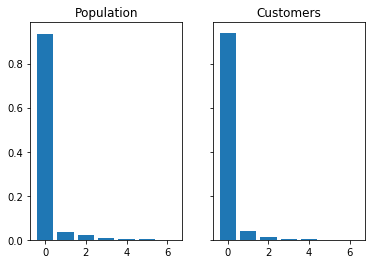

plot number:  68  plot name:  D19_KINDERARTIKEL


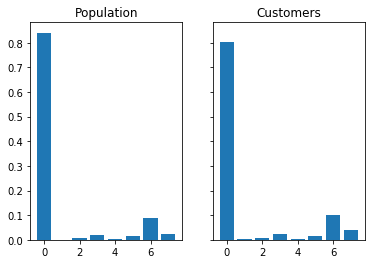

plot number:  69  plot name:  D19_WEIN_FEINKOST


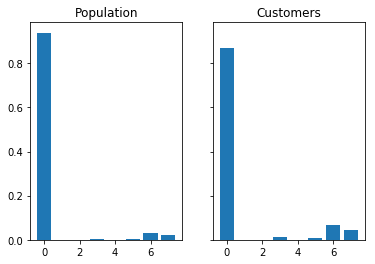

plot number:  70  plot name:  D19_LEBENSMITTEL


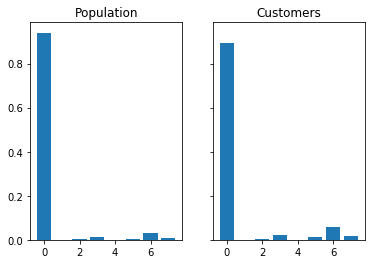

plot number:  71  plot name:  FINANZ_ANLEGER


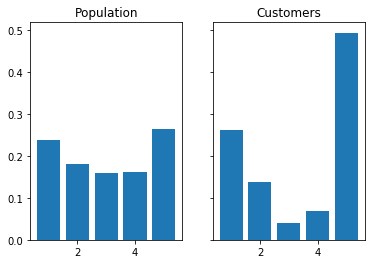

plot number:  72  plot name:  D19_VERSICHERUNGEN


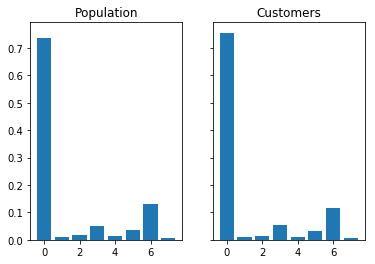

plot number:  73  plot name:  D19_VERSAND_ANZ_24


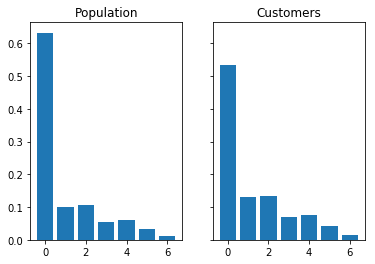

plot number:  74  plot name:  SEMIO_KAEM


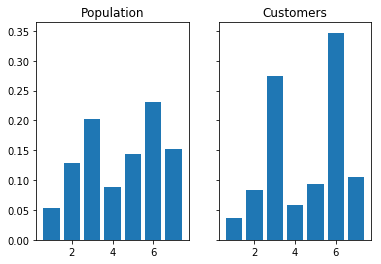

plot number:  75  plot name:  D19_RATGEBER


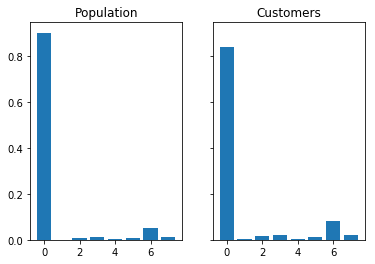

plot number:  76  plot name:  D19_GESAMT_DATUM


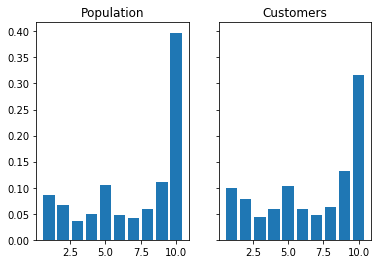

plot number:  77  plot name:  D19_VERSI_DATUM


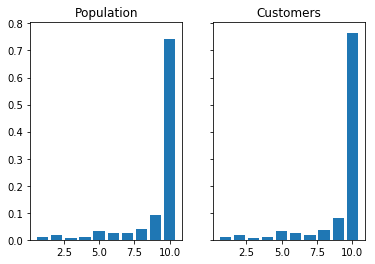

plot number:  78  plot name:  D19_GARTEN


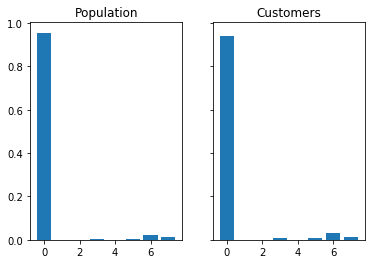

plot number:  79  plot name:  HEALTH_TYP


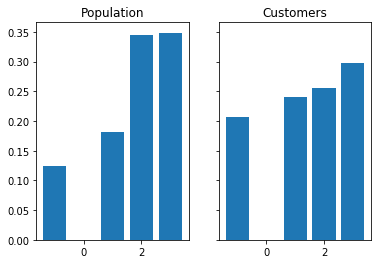

plot number:  80  plot name:  SEMIO_PFLICHT


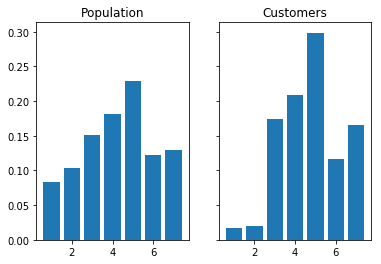

plot number:  81  plot name:  D19_VERSAND_ONLINE_DATUM


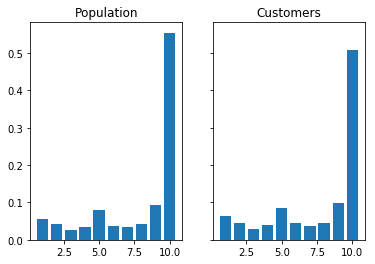

plot number:  82  plot name:  PRAEGENDE_JUGENDJAHRE


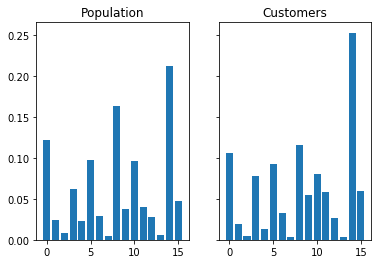

plot number:  83  plot name:  D19_BANKEN_DATUM


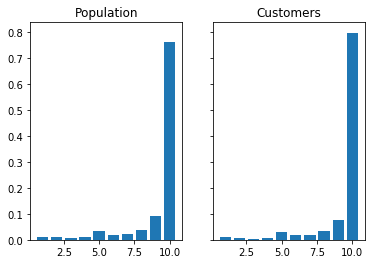

plot number:  84  plot name:  ANREDE_KZ


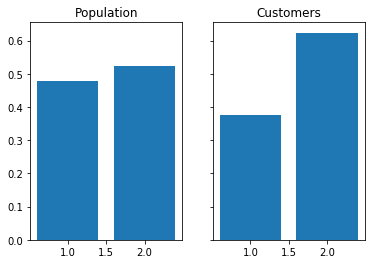

plot number:  85  plot name:  D19_VERSI_ANZ_12


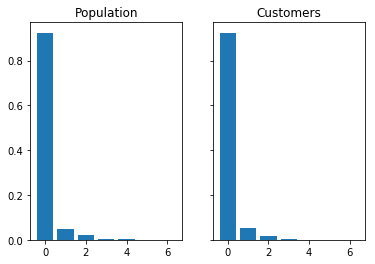

plot number:  86  plot name:  D19_DIGIT_SERV


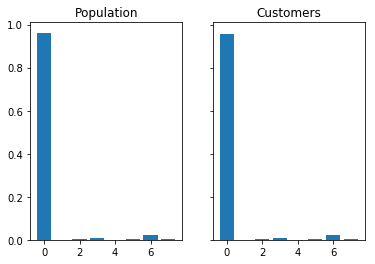

plot number:  87  plot name:  D19_KONSUMTYP_MAX


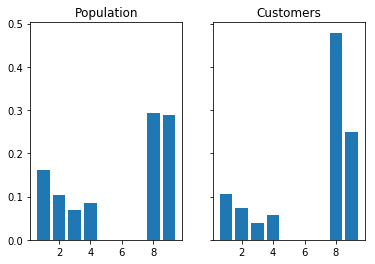

plot number:  88  plot name:  SEMIO_VERT


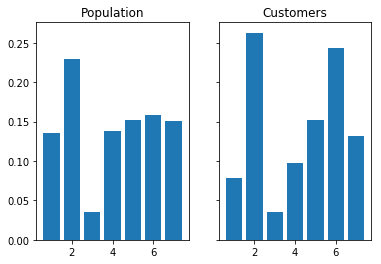

plot number:  89  plot name:  KOMBIALTER


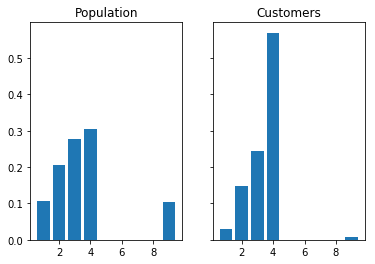

plot number:  90  plot name:  D19_SCHUHE


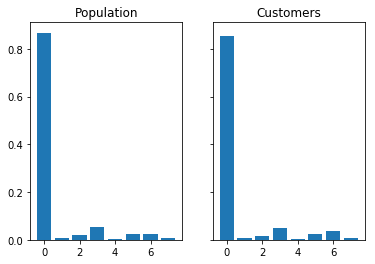

In [13]:
counter = 0 
for x in common:
    try:
        print('plot number: ',counter,' plot name: ',x)
        plot_comparison(new_azdias[x], new_customers[x], x)
        counter +=1 
        
    except ValueError:
        print('skipped feature')
      
    

In [14]:
#sns.heatmap(new_azdias.corr(method='spearman'))

In [15]:
customers.columns

Index(['LNR', 'AGER_TYP', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24',
       'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS',
       'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH',
       'D19_BEKLEIDUNG_REST', 'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD',
       'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT',
       'D19_GARTEN', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24',
       'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
       'D19_GESAMT_ONLINE_DATUM', 'D19_HANDWERK', 'D19_HAUS_DEKO',
       'D19_KINDERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_KOSMETIK',
       'D19_LEBENSMITTEL', 'D19_NAHRUNGSERGAENZUNG', 'D19_RATGEBER',
       'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE', 'D19_SONSTIGE',
       'D19_TECHNIK', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24',
       'D19_TELKO_DATUM', 'D19_TELKO_MOBILE', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_REST', 'D

In [16]:
#PCA analysis 

from sklearn.decomposition import PCA

#variable not sclaed
new_customers.drop('GEBURTSJAHR', inplace = True, axis = 1)

for x in range(20,len(new_customers.columns),10):
        
        pca = PCA(n_components = 4)

        data = pd.get_dummies(new_customers.iloc[:,1:x])

        pca.fit_transform(data) 

        print('Number of features: ', len(data.columns)," | ",pca.explained_variance_ratio_,'|', 'Sum ', sum(pca.explained_variance_ratio_))
        
        name_col = data.columns


Number of features:  19  |  [ 0.26803505  0.10986728  0.09207648  0.07688947] | Sum  0.546868272679
Number of features:  29  |  [ 0.36650601  0.07711225  0.05705073  0.04788864] | Sum  0.548557629485
Number of features:  39  |  [ 0.32364487  0.07195682  0.04661946  0.0383421 ] | Sum  0.480563242089
Number of features:  49  |  [ 0.33622782  0.07368787  0.04247567  0.03323218] | Sum  0.485623535917
Number of features:  59  |  [ 0.33896538  0.07234305  0.03783467  0.03159525] | Sum  0.480738350346
Number of features:  69  |  [ 0.32926782  0.07418289  0.04145564  0.02942643] | Sum  0.47433277891
Number of features:  79  |  [ 0.32485673  0.07082858  0.0456384   0.03541472] | Sum  0.476738425412
Number of features:  89  |  [ 0.32019912  0.07563053  0.04405737  0.04080261] | Sum  0.480689636077


In [17]:
a = pd.DataFrame(name_col)

In [18]:
b = pd.DataFrame(pca.components_).transpose()

In [19]:
b.shape

(89, 4)

In [20]:
pca_table = pd.merge(a, b, left_index=True, right_index=True)

pca_table.columns = ['feature', 'pca1', 'pca2', 'pca3', 'pca4']

pca_table.describe()

,pca1,pca2,pca3,pca4
count,89.000000,89.000000,89.000000,89.000000
mean,0.016268,0.000905,0.029853,0.020635
std,0.105337,0.106596,0.102285,0.104561
min,-0.280719,-0.311242,-0.529732,-0.350857
25%,-0.036858,-0.060419,-0.007239,-0.013028
50%,0.036671,0.009418,0.020240,0.018417
75%,0.085445,0.062697,0.086852,0.057438
max,0.251537,0.196513,0.263241,0.334430


In [21]:
pca_table[['feature','pca1']].sort_values(by = 'pca1', ascending = False)[:10]

,feature,pca1
71,PRAEGENDE_JUGENDJAHRE,0.251537
36,D19_SONSTIGE,0.180514
37,D19_TECHNIK,0.173716
85,SEMIO_VERT,0.164436
14,D19_BUCH_CD,0.162009
58,D19_VOLLSORTIMENT,0.160446
21,D19_GESAMT_ANZ_24,0.138150
29,D19_KOSMETIK,0.132869
33,D19_REISEN,0.131963
26,D19_HAUS_DEKO,0.130132


In [22]:
pca_table[['feature','pca2']].sort_values(by = 'pca2', ascending = False)[:10]

,feature,pca2
60,FINANZ_ANLEGER,0.196513
82,SEMIO_REL,0.190226
28,D19_KONSUMTYP_MAX,0.189650
64,FINANZ_UNAUFFAELLIGER,0.165413
69,KOMBIALTER,0.163089
21,D19_GESAMT_ANZ_24,0.156639
47,D19_VERSAND_ANZ_24,0.154424
63,FINANZ_SPARER,0.154230
80,SEMIO_PFLICHT,0.144673
76,SEMIO_KRIT,0.139651


In [23]:
pca_table[['feature','pca3']].sort_values(by = 'pca3', ascending = False)[:10]

,feature,pca3
29,D19_KOSMETIK,0.263241
33,D19_REISEN,0.233996
34,D19_SAMMELARTIKEL,0.224274
25,D19_HANDWERK,0.214345
69,KOMBIALTER,0.203023
12,D19_BILDUNG,0.171021
26,D19_HAUS_DEKO,0.163533
14,D19_BUCH_CD,0.158081
59,D19_WEIN_FEINKOST,0.149182
32,D19_RATGEBER,0.148516


In [24]:
pca_table[['feature','pca4']].sort_values(by = 'pca4', ascending = False)[:10]

,feature,pca4
74,SEMIO_FAM,0.334430
77,SEMIO_KULT,0.327416
82,SEMIO_REL,0.295939
79,SEMIO_MAT,0.253575
85,SEMIO_VERT,0.239268
37,D19_TECHNIK,0.150482
83,SEMIO_SOZ,0.143731
28,D19_KONSUMTYP_MAX,0.123449
84,SEMIO_TRADV,0.101766
34,D19_SAMMELARTIKEL,0.101203


In [25]:
pca1_feature_list = list(pca_table[['feature','pca1']].sort_values(by = 'pca1', ascending = False)[:10]['feature'])
pca1_feature_list

['PRAEGENDE_JUGENDJAHRE',
 'D19_SONSTIGE',
 'D19_TECHNIK',
 'SEMIO_VERT',
 'D19_BUCH_CD',
 'D19_VOLLSORTIMENT',
 'D19_GESAMT_ANZ_24',
 'D19_KOSMETIK',
 'D19_REISEN',
 'D19_HAUS_DEKO']

In [26]:
# k-means clustering 

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4, max_iter =200)

pred = kmeans.fit_predict(pca_table[['pca1','pca2']])

In [27]:
main_comp = pca_table[['pca1','pca2']]

In [28]:
def draw_clusters(dataset, predictions, cmap='viridis'):
    fig = plt.figure()

    clustered = pd.concat([dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(pca_table['pca1'], pca_table['pca2'] , c=clustered['group'], cmap=cmap)
    #plt.axis([-.005,.005,-.3,.3]) #[-.01,.02,0,0.2]
    plt.xlabel('First Component')
    plt.ylabel('Second Component')

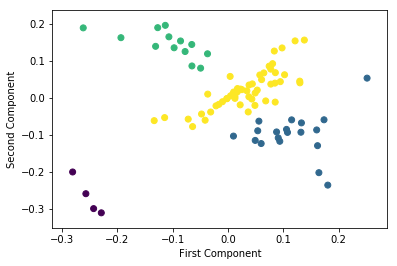

In [29]:
draw_clusters(main_comp, pred, cmap='viridis')

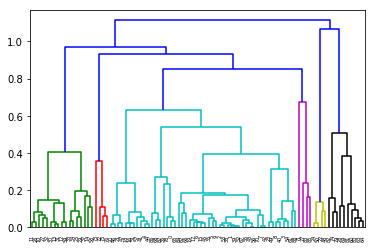

In [30]:
from scipy.cluster.hierarchy import dendrogram, ward, single 

Y = pca_table[['pca1','pca2','pca3', 'pca4']]

linkage_matrix = ward(Y.iloc[:891211]) 

dendrogram(linkage_matrix)

plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [31]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [33]:
response = mailout_train['RESPONSE']

In [34]:
new_mailout_train = trim_df(mailout_train, .0001)

In [35]:
new_mailout_train.head()

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,0,0,10,0,0,0,10,10,...,1,5,1,3,3,2,3,0,2,4
1,1771,1,1,1,5,0,0,3,10,10,...,3,1,3,4,2,1,1,0,2,3
2,1776,1,0,1,7,0,0,0,10,7,...,5,3,1,7,3,1,3,0,1,4
3,1460,2,0,0,10,0,0,0,10,10,...,2,5,3,2,1,2,3,0,2,4
4,1783,2,0,0,10,0,0,0,10,10,...,4,6,2,7,1,1,3,0,1,3


In [36]:
features = new_mailout_train.drop(['LNR', 'RESPONSE', 'GEBURTSJAHR' ], axis = 1)

In [37]:
features.shape

(42962, 91)

In [38]:
from sklearn.model_selection import train_test_split 

xtrain, xother, ytrain, yother = train_test_split(features, response, test_size = .25, random_state = 1)

xvalid, xtest, yvalid, ytest = train_test_split(xother, yother, test_size = .5, random_state = 2)

In [39]:
def pca_data(df, x):

    pca = PCA(n_components = x)

    data = pd.get_dummies(df)

    pca.fit_transform(data) 

    print('Number of components: ', x,'Sum ', sum(pca.explained_variance_ratio_))


In [40]:
for x in range(1,features.shape[1],10):
    pca_data(features, x)

Number of components:  1 Sum  0.272585465998
Number of components:  11 Sum  0.610119134983
Number of components:  21 Sum  0.758676032185
Number of components:  31 Sum  0.85090553804
Number of components:  41 Sum  0.916226913357
Number of components:  51 Sum  0.956790916094
Number of components:  61 Sum  0.981243528797
Number of components:  71 Sum  0.99348326828
Number of components:  81 Sum  0.998546689514


In [41]:
from sklearn.decomposition import RandomizedPCA

def pca_transform(df, x):
    pca = RandomizedPCA(n_components=x, whiten=True).fit(df)
    transformed_pca = pca.transform(df)
    return transformed_pca

In [42]:
xtrain_pca = pca_transform(xtrain, 81)
xvalid_pca = pca_transform(xvalid, 81)
xtest_pca = pca_transform(xtest, 81)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new imple

In [43]:
import keras

num_classes = 2
ytrain_cat = keras.utils.to_categorical(ytrain, num_classes)

yvalid_cat = keras.utils.to_categorical(yvalid, num_classes)

ytest_cat = keras.utils.to_categorical(ytest, num_classes)

Using TensorFlow backend.


In [44]:
sum(ytest)

62

In [45]:
sum(np.argmax(ytest_cat, axis =1))

62

In [46]:
ytest.iloc[20]

0

In [47]:
ytest_cat[20]

array([ 1.,  0.])

In [48]:
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

model = Sequential()

model.add(Dense(200, activation = 'relu', input_shape=(81,)))
model.add(Dropout(0.6))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(2, activation='softmax'))
model.summary()

adam = Adam(lr=0.0001, decay=0.0001)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               16400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total para

In [49]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
class_weight = {0: 1,
                1: 110}

predict = model.fit(xtrain_pca, ytrain_cat, validation_data=(xvalid_pca, yvalid_cat),
          epochs=200, batch_size=20, callbacks=[checkpointer], verbose=1, class_weight=class_weight)

Train on 32221 samples, validate on 5370 samples
Epoch 1/200
32221/32221 [==============================] - 5s 142us/step - loss: 2.1850 - acc: 0.4409 - val_loss: 0.8155 - val_acc: 0.0790
Epoch 2/200
32221/32221 [==============================] - 4s 126us/step - loss: 1.6496 - acc: 0.2150 - val_loss: 0.8960 - val_acc: 0.0145
Epoch 3/200
32221/32221 [==============================] - 4s 130us/step - loss: 1.6431 - acc: 0.1899 - val_loss: 0.8247 - val_acc: 0.1352
Epoch 4/200
32221/32221 [==============================] - 4s 136us/step - loss: 1.6903 - acc: 0.2869 - val_loss: 0.7499 - val_acc: 0.3410
Epoch 5/200
32221/32221 [==============================] - 5s 146us/step - loss: 1.6341 - acc: 0.2973 - val_loss: 0.5665 - val_acc: 0.6957
Epoch 6/200
32221/32221 [==============================] - 4s 128us/step - loss: 1.7680 - acc: 0.4030 - val_loss: 0.9126 - val_acc: 0.2335
Epoch 7/200
32221/32221 [==============================] - 4s 125us/step - loss: 1.7305 - acc: 0.3283 - val_loss: 0.6

Epoch 32/200
32221/32221 [==============================] - 4s 128us/step - loss: 1.4829 - acc: 0.5279 - val_loss: 0.7648 - val_acc: 0.5194
Epoch 33/200
32221/32221 [==============================] - 4s 129us/step - loss: 1.4162 - acc: 0.5352 - val_loss: 0.6544 - val_acc: 0.5629
Epoch 34/200
32221/32221 [==============================] - 4s 126us/step - loss: 1.6142 - acc: 0.5447 - val_loss: 0.9039 - val_acc: 0.4568
Epoch 35/200
32221/32221 [==============================] - 4s 129us/step - loss: 1.6109 - acc: 0.5313 - val_loss: 0.8237 - val_acc: 0.4994
Epoch 36/200
32221/32221 [==============================] - 4s 127us/step - loss: 1.5979 - acc: 0.5462 - val_loss: 0.7299 - val_acc: 0.5676
Epoch 37/200
32221/32221 [==============================] - 4s 128us/step - loss: 2.1148 - acc: 0.5721 - val_loss: 0.7322 - val_acc: 0.6047
Epoch 38/200
32221/32221 [==============================] - 4s 127us/step - loss: 1.8161 - acc: 0.5911 - val_loss: 0.8746 - val_acc: 0.5309
Epoch 39/200
32221/3

Epoch 64/200
32221/32221 [==============================] - 4s 136us/step - loss: 1.8800 - acc: 0.6885 - val_loss: 0.7623 - val_acc: 0.6695
Epoch 65/200
32221/32221 [==============================] - 4s 132us/step - loss: 1.7945 - acc: 0.6440 - val_loss: 0.9253 - val_acc: 0.5561
Epoch 66/200
32221/32221 [==============================] - 4s 127us/step - loss: 1.3893 - acc: 0.6407 - val_loss: 0.7336 - val_acc: 0.6430
Epoch 67/200
32221/32221 [==============================] - 4s 125us/step - loss: 1.5889 - acc: 0.6468 - val_loss: 0.7707 - val_acc: 0.6365
Epoch 68/200
32221/32221 [==============================] - 4s 126us/step - loss: 1.3330 - acc: 0.6573 - val_loss: 0.6486 - val_acc: 0.6641
Epoch 69/200
32221/32221 [==============================] - 4s 126us/step - loss: 1.5588 - acc: 0.6495 - val_loss: 0.7508 - val_acc: 0.6421
Epoch 70/200
32221/32221 [==============================] - 4s 130us/step - loss: 1.5746 - acc: 0.6560 - val_loss: 0.6927 - val_acc: 0.6728
Epoch 71/200
32221/3

Epoch 96/200
32221/32221 [==============================] - 4s 128us/step - loss: 1.3434 - acc: 0.6706 - val_loss: 0.7203 - val_acc: 0.6512
Epoch 97/200
32221/32221 [==============================] - 4s 129us/step - loss: 1.5995 - acc: 0.6841 - val_loss: 0.7128 - val_acc: 0.6723
Epoch 98/200
32221/32221 [==============================] - 4s 126us/step - loss: 1.2594 - acc: 0.7046 - val_loss: 0.6793 - val_acc: 0.6810
Epoch 99/200
32221/32221 [==============================] - 4s 128us/step - loss: 2.1387 - acc: 0.6893 - val_loss: 0.7505 - val_acc: 0.6603
Epoch 100/200
32221/32221 [==============================] - 4s 126us/step - loss: 1.5188 - acc: 0.6752 - val_loss: 0.6375 - val_acc: 0.7000
Epoch 101/200
32221/32221 [==============================] - 4s 125us/step - loss: 1.2407 - acc: 0.6821 - val_loss: 0.6865 - val_acc: 0.6791
Epoch 102/200
32221/32221 [==============================] - 4s 125us/step - loss: 1.3758 - acc: 0.6803 - val_loss: 0.6716 - val_acc: 0.6968
Epoch 103/200
322

32221/32221 [==============================] - 4s 127us/step - loss: 1.3621 - acc: 0.6905 - val_loss: 0.6228 - val_acc: 0.7058
Epoch 128/200
32221/32221 [==============================] - 4s 133us/step - loss: 1.6346 - acc: 0.6968 - val_loss: 0.7241 - val_acc: 0.6492
Epoch 129/200
32221/32221 [==============================] - 5s 155us/step - loss: 2.7492 - acc: 0.6903 - val_loss: 0.8004 - val_acc: 0.6419
Epoch 130/200
32221/32221 [==============================] - 5s 161us/step - loss: 2.3486 - acc: 0.6881 - val_loss: 0.7397 - val_acc: 0.6564
Epoch 131/200
32221/32221 [==============================] - 4s 137us/step - loss: 2.1952 - acc: 0.6911 - val_loss: 0.7096 - val_acc: 0.6644
Epoch 132/200
32221/32221 [==============================] - 4s 129us/step - loss: 1.9054 - acc: 0.6813 - val_loss: 0.7298 - val_acc: 0.6436
Epoch 133/200
32221/32221 [==============================] - 5s 146us/step - loss: 2.4037 - acc: 0.6761 - val_loss: 0.6956 - val_acc: 0.6708
Epoch 134/200
32221/32221 [

32221/32221 [==============================] - 4s 136us/step - loss: 4.4599 - acc: 0.7306 - val_loss: 0.7771 - val_acc: 0.6661
Epoch 159/200
32221/32221 [==============================] - 4s 135us/step - loss: 3.9874 - acc: 0.7075 - val_loss: 0.7829 - val_acc: 0.6549
Epoch 160/200
32221/32221 [==============================] - 4s 129us/step - loss: 3.1355 - acc: 0.7107 - val_loss: 0.7744 - val_acc: 0.6581
Epoch 161/200
32221/32221 [==============================] - 4s 133us/step - loss: 2.6672 - acc: 0.7102 - val_loss: 0.7212 - val_acc: 0.6717
Epoch 162/200
32221/32221 [==============================] - 4s 129us/step - loss: 2.5615 - acc: 0.7043 - val_loss: 0.7021 - val_acc: 0.6762
Epoch 163/200
32221/32221 [==============================] - 4s 136us/step - loss: 2.7179 - acc: 0.7052 - val_loss: 0.7172 - val_acc: 0.6689
Epoch 164/200
32221/32221 [==============================] - 5s 140us/step - loss: 2.4505 - acc: 0.6990 - val_loss: 0.7015 - val_acc: 0.6706
Epoch 165/200
32221/32221 [

32221/32221 [==============================] - 4s 130us/step - loss: 3.8690 - acc: 0.7009 - val_loss: 0.7716 - val_acc: 0.6508
Epoch 190/200
32221/32221 [==============================] - 4s 130us/step - loss: 3.8564 - acc: 0.7170 - val_loss: 0.7241 - val_acc: 0.6650
Epoch 191/200
32221/32221 [==============================] - 4s 127us/step - loss: 2.7435 - acc: 0.6975 - val_loss: 0.7277 - val_acc: 0.6475
Epoch 192/200
32221/32221 [==============================] - 4s 137us/step - loss: 2.5118 - acc: 0.7191 - val_loss: 0.6980 - val_acc: 0.6788
Epoch 193/200
32221/32221 [==============================] - 4s 129us/step - loss: 4.5332 - acc: 0.7341 - val_loss: 0.7333 - val_acc: 0.6693
Epoch 194/200
32221/32221 [==============================] - 4s 128us/step - loss: 4.3796 - acc: 0.7409 - val_loss: 0.7423 - val_acc: 0.6730
Epoch 195/200
32221/32221 [==============================] - 4s 129us/step - loss: 3.3899 - acc: 0.7148 - val_loss: 0.7645 - val_acc: 0.6624
Epoch 196/200
32221/32221 [

In [50]:
predict.history

{'val_loss': [0.8154828314230651,
  0.89596595977271731,
  0.82472072211501768,
  0.74993326965879015,
  0.56652437663833077,
  0.91261015923995548,
  0.68242594882762631,
  0.76818037721253862,
  0.70236665465534287,
  0.86518698486757895,
  1.1513555833525275,
  0.63540261162503919,
  0.82128657786317827,
  0.63842806314400902,
  1.0086754160886371,
  0.63714247830975212,
  0.92013536596209422,
  0.86652239962885058,
  0.88232831071430962,
  0.9117024828379825,
  0.8560920507548242,
  0.74568379302708576,
  0.65343360172747678,
  0.70998138200415362,
  0.6686803797325831,
  0.79133452755334877,
  0.87068551545702544,
  0.79601448319255752,
  0.67497803379037524,
  0.7940911598489715,
  0.67982319302621053,
  0.76479956479933897,
  0.65438278466185595,
  0.90393321207781741,
  0.8236531728472789,
  0.72991361969898094,
  0.73216192998699636,
  0.87460906023863749,
  0.87559404841570432,
  0.85427190760216454,
  0.84652845209093286,
  0.84483001873701868,
  0.87406702736458519,
  0.865

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


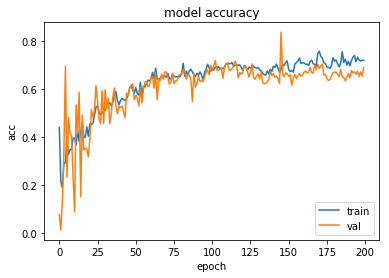

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

print(predict.history.keys())
plt.plot(predict.history['acc'])
plt.plot(predict.history['val_acc'])
plt.title('model accuracy')
plt.ylabel(model.metrics_names[1])
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [52]:
model.load_weights('model.weights.best.hdf5')
model.metrics_names

['loss', 'acc']

In [53]:
score = model.evaluate(xtest_pca, ytest_cat, verbose=1)
print('\n', model.metrics_names[1], score[1])

5371/5371 [==============================] - 0s 28us/step

 acc 0.903183764773


In [54]:
predictions = model.predict(xtest_pca,verbose =1)
predictions

5371/5371 [==============================] - 0s 25us/step


array([[ 0.98754835,  0.01245165],
       [ 0.71949273,  0.2805073 ],
       [ 1.        ,  0.        ],
       ..., 
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ]], dtype=float32)

In [55]:
model_pred = np.argmax(predictions, axis = 1)

In [56]:
sum(model_pred)

474

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pylab as pl

In [58]:
matrix = confusion_matrix(ytest, model_pred)
print(matrix)

[[4843  466]
 [  54    8]]


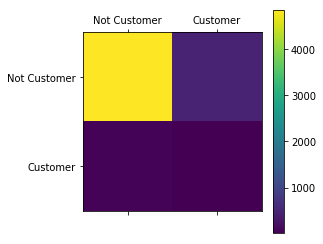

In [59]:
pl.figure()

color_matrix = pl.matshow(matrix)

pl.xticks(range(2),['Not Customer','Customer'])
pl.yticks(range(2),['Not Customer','Customer'])

pl.colorbar(color_matrix)

pl.show()

In [60]:
print(classification_report(np.asarray(ytest), model_pred))

             precision    recall  f1-score   support

          0       0.99      0.91      0.95      5309
          1       0.02      0.13      0.03        62

avg / total       0.98      0.90      0.94      5371



In [61]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(np.asarray(ytest), model_pred)
auc

0.52062839122852844

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [62]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [64]:
kaggle_test = trim_df(mailout_test, .0001)

In [65]:
kaggle_test.head()

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,0,0,10,0,0,0,10,10,...,1,2,6,1,7,3,1,3,1,4
1,1770,-1,0,0,10,0,0,0,10,10,...,3,3,6,1,6,2,1,3,1,4
2,1465,2,0,0,10,0,0,0,10,10,...,3,1,4,3,3,3,1,3,2,4
3,1470,-1,0,0,10,0,0,0,10,10,...,3,2,3,3,2,3,2,3,2,4
4,1478,1,3,4,2,2,2,0,8,2,...,3,2,5,3,3,3,1,4,2,4


In [66]:
output_table = pd.DataFrame(kaggle_test['LNR'])

In [67]:
kaggle_test_features = kaggle_test.drop(['LNR', 'GEBURTSJAHR' ], axis = 1)

In [68]:
kaggle_test_features_pca = pca_transform(kaggle_test_features, 81)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [69]:
kaggle_test_preds = model.predict(kaggle_test_features_pca,verbose =1)
kaggle_test_preds

42833/42833 [==============================] - 1s 24us/step


array([[  1.00000000e+00,   4.58956512e-10],
       [  9.99999881e-01,   7.53969189e-08],
       [  1.00000000e+00,   0.00000000e+00],
       ..., 
       [  1.00000000e+00,   0.00000000e+00],
       [  9.99999762e-01,   2.28187815e-07],
       [  1.00000000e+00,   0.00000000e+00]], dtype=float32)

In [70]:
kaggle_test_preds[:,1]

array([  4.58956512e-10,   7.53969189e-08,   0.00000000e+00, ...,
         0.00000000e+00,   2.28187815e-07,   0.00000000e+00], dtype=float32)

In [71]:
np.round(kaggle_test_preds[:,1], 5)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [72]:
output_table['RESPONSE'] = np.round(kaggle_test_preds[:,1], 5)

In [73]:
output_table.head()

,LNR,RESPONSE
0,1754,0.0
1,1770,0.0
2,1465,0.0
3,1470,0.0
4,1478,0.0


In [74]:
output_table.to_csv('output_table.csv')